# Forecasting Monthly Receipt Counts using timeseries model - Jazil's notebook

![](receiptcount.jpg)

### Key Steps and Approaches

#### Data Exploration and Analysis
* Conduct a thorough examination of the daily receipt data to identify trends, patterns, and anomalies.
* Utilize exploratory data analysis (EDA) techniques to uncover potential features that could be predictive.

#### Data Preprocessing and Transformation
* Convert the data to a stationary series using Box-Cox transformations and differencing to ensure model stability.
* Analyze autocorrelation to determine the optimal lag values for the time series model.

#### Model Development
* Implement a custom ARIMA model incorporating moving average techniques to assess errors and predict future values.
* Tailor the model to accurately forecast monthly receipt counts.

#### Model Deployment and Evaluation
* Predict monthly receipt counts for the next year using appropriate conversion and scaling techniques.
* Develop custom functions to avoid reliance on external libraries.
* Save the trained model in a pickle file for future use.
* Create an interactive user interface using a Flask server to host the model at runtime.
* Package the application in a Docker container for easy deployment and reusability.

**Overall, this project aims to leverage time series forecasting techniques to provide valuable insights into future receipt trends, enabling informed decision-making and resource planning.**

In [210]:
# LOADING LIBRARIES

import pandas as pd
import numpy as np
import datetime
from operator import itemgetter
import math
import os
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import date
import pickle

In [212]:
#Loading dataset
df=pd.read_csv('D:\\Detritus\\Fetch Assignment\\data_daily.csv')

## Data Checks and Processing

In [215]:
df.head()

,# Date,Receipt_Count
0,2021-01-01,7564766
1,2021-01-02,7455524
2,2021-01-03,7095414
3,2021-01-04,7666163
4,2021-01-05,7771289


In [238]:
df.shape

(365, 8)

In [217]:
df.columns

Index(['# Date', 'Receipt_Count'], dtype='object')

In [219]:
df=df.rename(columns={'# Date':'Date'})

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           365 non-null    object
 1   Receipt_Count  365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [223]:
df['Date']=pd.to_datetime(df['Date'])

In [225]:
df.isna().sum()

Date             0
Receipt_Count    0
dtype: int64

## Feature Engineering and EDA

Text(0.5, 1.0, 'Daily Receipt Count for 2021')

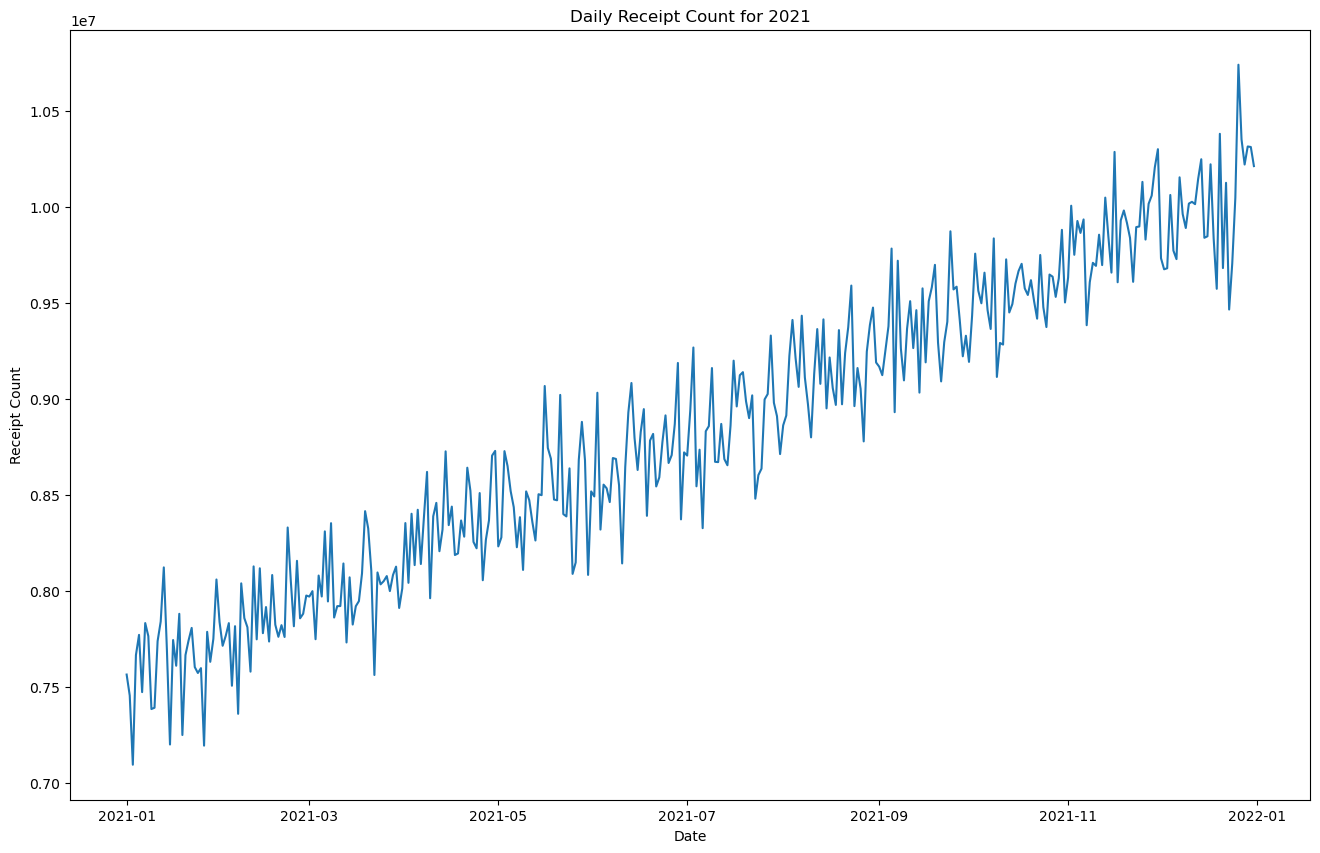

In [232]:
plt.figure(figsize=(16,10))
plt.plot(df['Date'],df['Receipt_Count'])
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.title('Daily Receipt Count for 2021')

#### From above plot, count is increasing with time in a stable manner and has a variance which remains consistent with time

### Dividing data in different time intervals to see if we have any trend

In [234]:
df['Date'].max()
df['Month']=df['Date'].dt.month
df['Quarter']=df['Date'].dt.quarter
df['dayofweek']=df['Date'].dt.dayofweek
df['dayofmonth']=df['Date'].dt.day

day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['dayname']=df['dayofweek'].map(day_names)

df['is_weekend']=1
df.loc[df['dayofweek'].isin([0,1,2,3,4]),'is_weekend']=0

In [236]:
df.head()

,Date,Receipt_Count,Month,Quarter,dayofweek,dayofmonth,dayname,is_weekend
0,2021-01-01,7564766,1,1,4,1,Friday,0
1,2021-01-02,7455524,1,1,5,2,Saturday,1
2,2021-01-03,7095414,1,1,6,3,Sunday,1
3,2021-01-04,7666163,1,1,0,4,Monday,0
4,2021-01-05,7771289,1,1,1,5,Tuesday,0


In [240]:
pd.set_option('display.float_format', lambda x: f'{x:.0f}')
#print(df)

#### Task is to predict monthly total receipts for next year so we convert daily data to monthly

Text(0, 0.5, 'Montly Sum of Receipt Count')

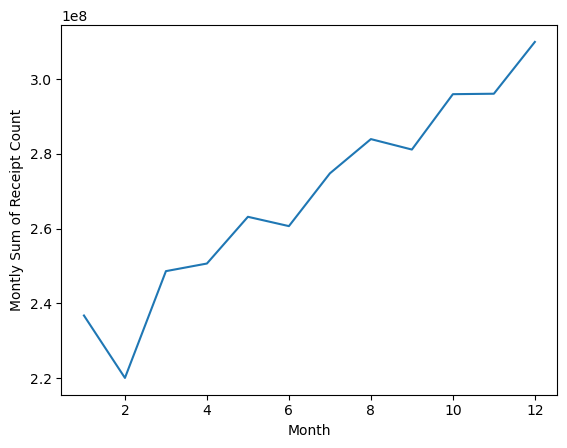

In [247]:
plot_a=df.groupby('Month')['Receipt_Count'].sum().reset_index(name='Count')
plt.plot(plot_a['Month'],plot_a['Count'])
plt.xlabel('Month')
plt.ylabel('Montly Sum of Receipt Count')

### From above plot, february has a drop due to lower number of days compared with rest of the months. Lets see if the average number of receipt per day for a month has a better trend

Text(0, 0.5, 'Montly Average of Daily Receipt Count')

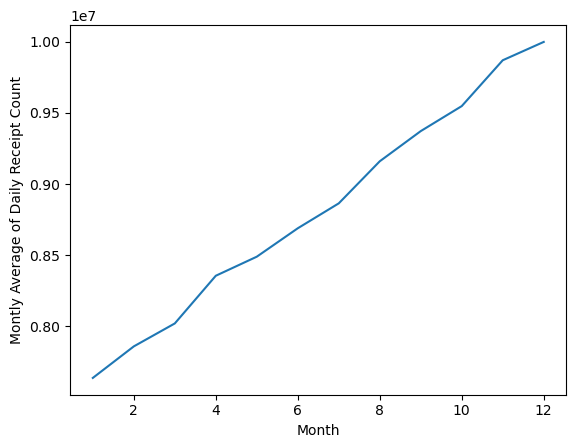

In [254]:
plot1=df.groupby('Month')['Receipt_Count'].mean().reset_index(name='Count')
plt.plot(plot1['Month'],plot1['Count'])
plt.xlabel('Month')
plt.ylabel('Montly Average of Daily Receipt Count')

### From above plot, daily average of a month has now a pretty good and stable trend so we will use this to predict future month's daily averages

#### Checking quarterly trend

<BarContainer object of 4 artists>

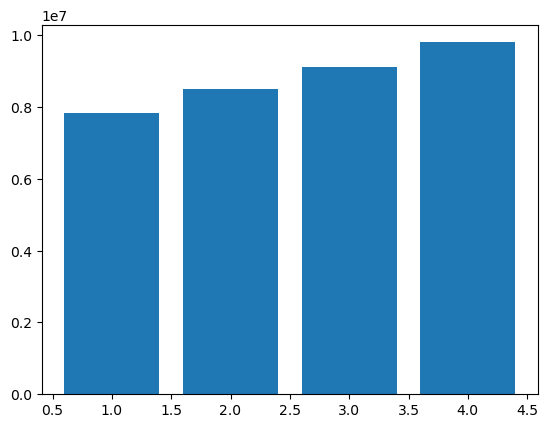

In [262]:
plot3=df.groupby('Quarter')['Receipt_Count'].mean().reset_index(name='Count')

plt.bar(plot3['Quarter'],plot3['Count'])

### Checking Weekday trend

<BarContainer object of 7 artists>

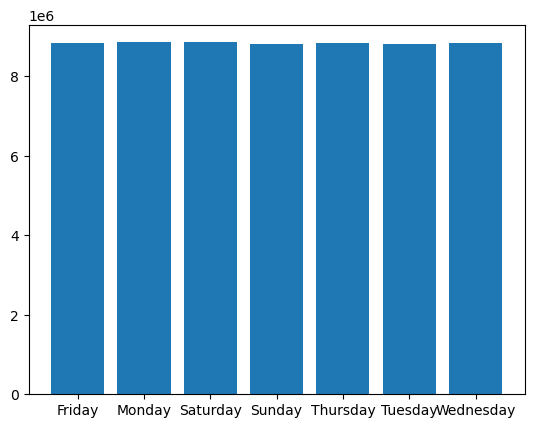

In [268]:
plot2=df.groupby('dayname')['Receipt_Count'].mean().reset_index(name='Count')

plt.bar(plot2['dayname'],plot2['Count'])

### Checking day of the month trend

<BarContainer object of 31 artists>

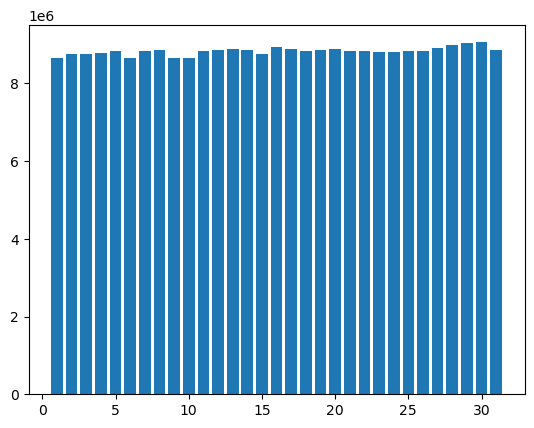

In [271]:
plot3=df.groupby('dayofmonth')['Receipt_Count'].mean().reset_index(name='Count')

plt.bar(plot3['dayofmonth'],plot3['Count'])

### Checking Weekend Trend

<BarContainer object of 2 artists>

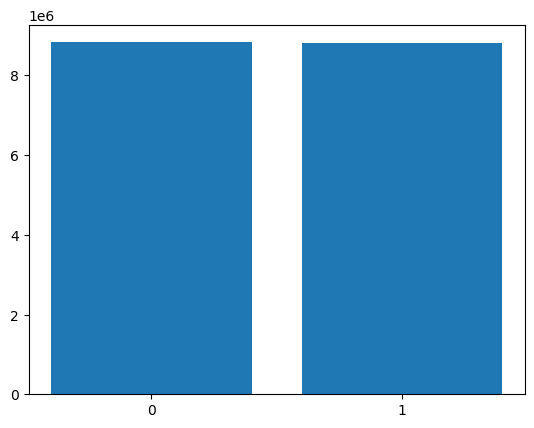

In [277]:
plot4=df.groupby('is_weekend')['Receipt_Count'].mean().reset_index(name='Count')
plot4['is_weekend']=plot4['is_weekend'].astype('str')
plt.bar(plot4['is_weekend'],plot4['Count'])

#### From above EDA, we see if don't have any trend for a weekend, weekday, month day or quarter. The best trend we saw is the average daily count per month which is increasing in a stable manner and precitable

## Model Building

### Model Data Processing and Optimal Parameters Finding


In [311]:
data=df.groupby('Month')['Receipt_Count'].mean().reset_index(name='Count')

In [313]:
data['Count']

0    7636667
1    7858338
2    8019633
3    8354828
4    8488766
5    8688561
6    8863742
7    9159459
8    9371538
9    9547264
10   9869505
11   9998345
Name: Count, dtype: float64

## What is the Box-Cox Transform?

The Box-Cox transform is a technique used to normalize non-normal data, making it resemble a normal distribution. This is crucial for fitting certain statistical models, like ARIMA, which rely on maximum likelihood estimation (MLE) that assumes a normal distribution.

**The Box-Cox transformation is parameterized by λ:**

* **If λ ≠ 0:** $$y(\lambda) = \frac{y^{\lambda}-1}{\lambda}$$
* **If λ = 0:** $$y(\lambda) = ln(y)$$

**Different values of λ correspond to different transformations:**

* **λ = 0:** Natural log transform
* **λ = 0.5:** Square root transform
* **λ = 1:** No transformation
* **λ = 3:** Cubic transform

**The optimal value of λ is chosen based on how well it approximates the transformed data to a normal ftware packages.

In [316]:
# Function to apply the Box-Cox transformation
def manual_boxcox(data, lmbda):
    if not np.all(data > 0):
        raise ValueError("All data must be positive for Box-Cox transformation.")
    if lmbda == 0:
        return np.log(data)
    else:
        return (np.power(data, lmbda) - 1) / lmbda

### Log-Likelihood with Jacobian Adjustment

This function computes the **log-likelihood** of transformed data for normality testing, with an adjustment using the **Jacobian** to account for data transformations like Box-Cox. The goal is to check whether the transformed data follows a normal distribution.

#### Key Concepts:

1. **Log-Likelihood (LL)**:  
   This measures how well the transformed data fits a normal distribution. The formula for the log-likelihood of the transformed data `x_t` (with mean `μ` and standard deviation `σ`) is:

   LL_transformed = sum(log(1 / sqrt(2 * pi * sigma^2) * exp(-(x_t_i - mu)^2 / (2 * sigma^2))))

   Simplified using the log of the normal distribution probability density function (PDF):

   LL_transformed = sum(log(norm.pdf(x_t_i, mu, sigma)))

   where `norm.logpdf()` from `scipy.stats` is used in the function.

2. **Jacobian Term**:  
   When applying a transformation (e.g., Box-Cox) to the data, the Jacobian determinant accounts for the change in scale. For the Box-Cox transformation, the Jacobian term is:

   J = (λ - 1) * sum(log(x_i))

   where `λ` is the transformation parameter, and `x_i` represents the original data points.

#### Combined Log-Likelihood with Jacobian Adjustment:

The total log-likelihood considering the transformation is the sum of the log-likelihood of the transformed data and the Jacobian term:

LL_total = LL_transformed + J

This adjusted log-likelihood helps assess if the transformed data ollows a normal distribution.
) is:



In [319]:
# Log-likelihood calculation including the Jacobian term
def log_likelihood_with_jacobian(data, transformed_data, lmbda):
    n = len(data)
    mean = np.mean(transformed_data)
    std = np.std(transformed_data, ddof=1)
    ll_transformed = np.sum(norm.logpdf(transformed_data, loc=mean, scale=std))
    jacobian_term = (lmbda - 1) * np.sum(np.log(data))
    return ll_transformed + jacobian_term

### This function actual tries a range of lambda values for boxcox transformation and outputs the best lambda value which can transform our data to the closet one to a normal distribution

In [322]:
# Finding the optimal lambda based on maximizing log-likelihood
def find_optimal_lambda_ll_with_jacobian(data, lmbda_range=(-2, 2), num_steps=100):
    best_lmbda = None
    max_log_likelihood = -np.inf
    for lmbda in np.linspace(lmbda_range[0], lmbda_range[1], num_steps):
        transformed_data = manual_boxcox(data, lmbda)
        ll = log_likelihood_with_jacobian(data, transformed_data, lmbda)
        if ll > max_log_likelihood:
            max_log_likelihood = ll
            best_lmbda = lmbda
    return best_lmbda



In [324]:
optimal_lambda_ll_jacobian = find_optimal_lambda_ll_with_jacobian(data['Count'], num_steps=1000)  # Increase steps for accuracy
optimal_lambda_ll_jacobian

0.5185185185185186

#### Best lambda =0.51, lets convert our data and see if we have a better trend

In [329]:
data['Boxcox_Count']=manual_boxcox(data[['Count']],0.51)

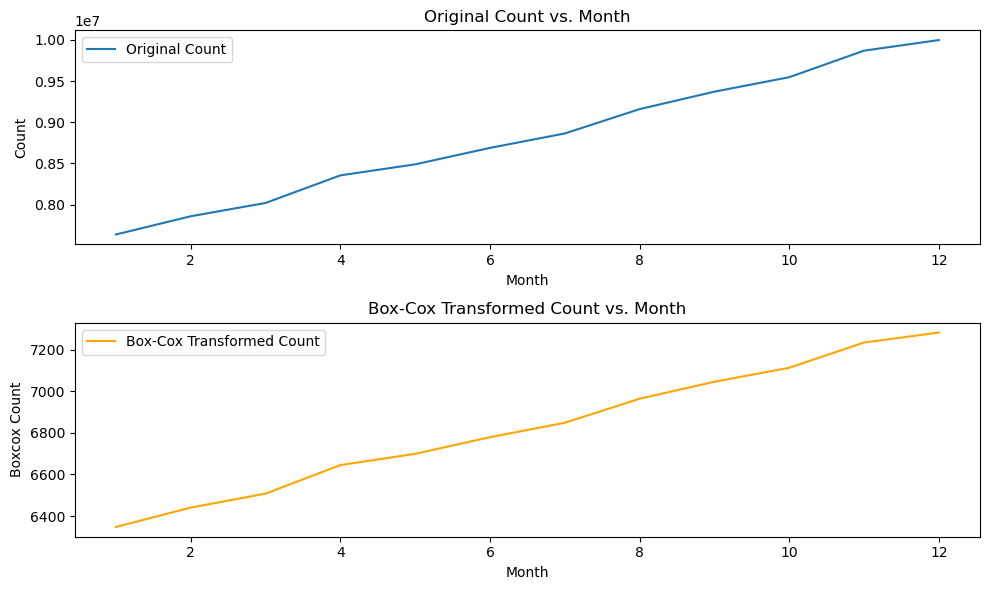

In [331]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# First subplot: plot 'Count' vs. 'Month'
ax[0].plot(data['Month'], data['Count'], label='Original Count')
ax[0].set_title('Original Count vs. Month')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Count')
ax[0].legend()

# Second subplot: plot 'Boxcox_Count' vs. 'Month'
ax[1].plot(data['Month'], data['Boxcox_Count'], label='Box-Cox Transformed Count', color='orange')
ax[1].set_title('Box-Cox Transformed Count vs. Month')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Boxcox Count')
ax[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

#### Overall the trend is very similar, boxcox has scaled the counts but trend is pretty much the same. Hence we don't need the transformation and can use the raw counts in our model. This also helps us to save computation in converting the predictions back if we opted for boxcox transformation

## Time Series Stationary

**What is Stationarity?**

A time series is considered stationary if its statistical properties, such as mean and variance, remain constant over time. In other words, it doesn't exhibit any long-term trends or obvious seasonality.

**Key characteristics of a stationary time series:**

* **Constant mean:** The average value of the series remains consistent over time.
* **Constant variance:** The variability of the data points around the mean stays the same over time.
* **No time-dependent structure:** The statistical properties of the series do not change with time.



**Making a Time Series Stationary**

To make a non-stationary time series stationary, various transformations can be applied. One common method is **differencing**.

**Differencing**

Differencing involves taking the difference between consecutive data points. This can help remove trends and seasonality from the data.

The formula for differencing is:

$$d(t) = y(t) - y(t-1)$$

where:

* \(d(t)\) is the differenced series at time t.
* \(y(t)\) is the original series at time t.
* \(y(t-1)\) is the original series at time t-1.

By applying differencing, you can often transform a non-stationary time series into a stationary one, making it suitable for analysis using many statistical models.

In [337]:
data['Count_Stationary']=data['Boxcox_Count'].diff()

In [341]:
##First value is NA so we drop it
data.dropna(inplace=True)
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


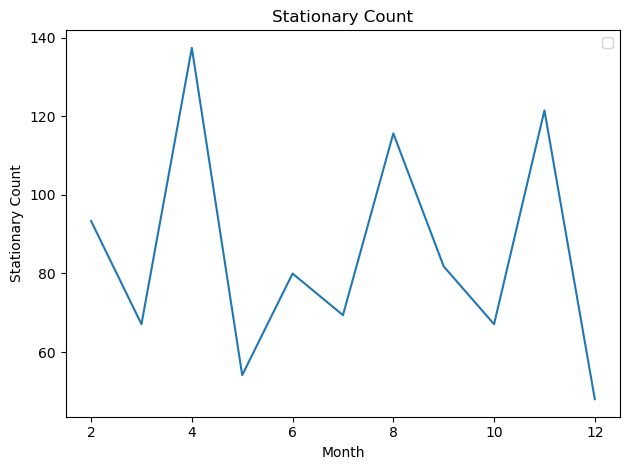

In [343]:
plt.plot(data['Month'],data['Count_Stationary'])
plt.title('Stationary Count')
plt.xlabel('Month')
plt.ylabel('Stationary Count')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

#### From above plot, data is stationary and not increasing and decreasing in a certain direction but is oscillating between a mean line

## Autocorrelation 

**Autocorrelation** is a statistical measure that quantifies the correlation between a time series and lagged versions of itself. It provides valuable insights into the characteristics of the data, such as seasonality and trends.

**Formula for Autocorrelation:**

$$r_k = \frac{\sum_{t=k+1}^{N} (y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum_{t=1}^{N} (y_t - \bar{y})^2}$$

where:

* \(r_k\) is the autocorrelation coefficient at lag k.
* \(y_t\) is the value of the time series at time t.
* \(\bar{y}\) is the mean of the time series.
* \(N\) is the length of the time series.

**Interpreting Autocorrelation:**

* **Seasonality:** If the autocorrelation coefficients are significantly higher at certain lag multiples (e.g., 7 for weekly seasonality), it indicates a repeating pattern in the data.
* **Trends:** A decreasing autocorrelation pattern for recent lags, with higher values for smaller lags, suggests a trend in the data. This means the values at nearby time points are more correlated than those further apart.
* **Randomness:** If the autocorrelation coefficients are close to zero for all lags, it suggests that the data is random and has no significant patterns.

**By analyzing the autocorrelation function, you can gain valuable insights into the underlying structure of your time series data and make informed decisions for modeling and analysis.**

In [353]:
def compute_acf_updated(x, nlags=40):
    """
    Compute the autocorrelation function (ACF) for a time series, normalized.
    
    Parameters:
    x : array-like
        Time series data.
    nlags : int
        Number of lags for which to compute the ACF.
    
    Returns:
    acf : array
        The autocorrelations for lags 0 through nlags.
    """
    n = len(x)
    mean_x = np.mean(x)
    
    # Subtract the mean to center the data
    x_centered = x - mean_x
    acf = np.zeros(nlags + 1)
    
    # Autocovariance at lag 0 is the variance
    acf[0] = 1  # The ACF at lag 0 is always 1 (since it's perfectly correlated with itself)
    
    # Compute autocorrelations for each lag
    for lag in range(1, nlags + 1):
        # Use np.correlate for efficient covariance computation
        acf[lag] = np.sum(x_centered[:n - lag] * x_centered[lag:]) / np.sum(x_centered ** 2)
    
    return acf

def plot_acf_manual_updated(x, nlags=40, alpha=0.05):
    """
    Manually plot the autocorrelation function (ACF).
    
    Parameters:
    x : array-like
        Time series data.
    nlags : int
        Number of lags to compute ACF for.
    alpha : float
        Significance level for confidence intervals.
    
    Returns:
    None
    """
    # Compute ACF values
    acf_values = compute_acf_updated(x, nlags)
    
    # Confidence intervals based on Bartlett's formula for white noise
    confint = 1.96 / np.sqrt(len(x))  # 95% confidence interval

    # Plot the ACF
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(range(nlags + 1), acf_values, width=0.4, color='blue', label='ACF')
    
    # Plot confidence intervals
    ax.axhline(y=confint, linestyle='--', color='red', label='Confidence Interval (95%)')
    ax.axhline(y=-confint, linestyle='--', color='red')
    ax.axhline(y=0, linestyle='-', color='black')
    
    # Set labels and title
    ax.set_xlabel('Lags')
    ax.set_ylabel('ACF')
    ax.set_title('Autocorrelation Function (ACF)')
    plt.legend()
    
    plt.show()

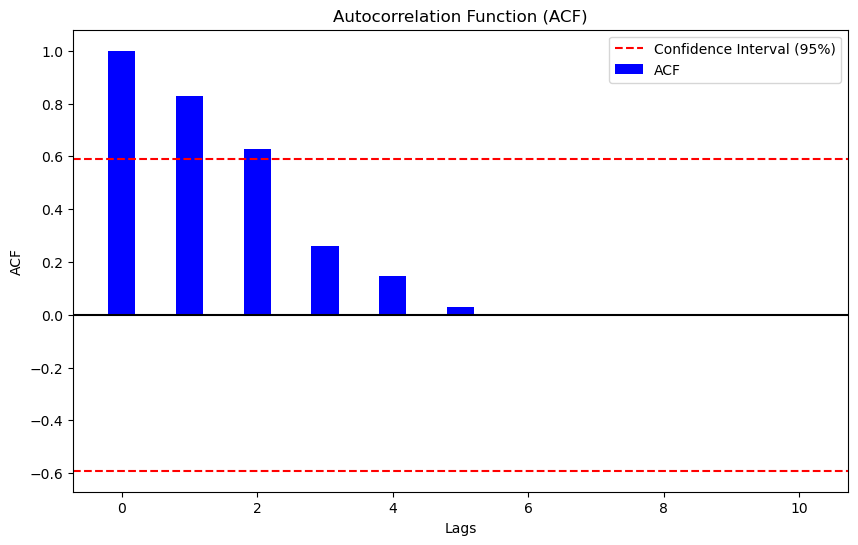

In [361]:
  # Random data (normally distributed)
plot_acf_manual_updated(data['Count_Stationary'], nlags=10)

#### From above plot, we see that highest correlation value is with a lag value of 1. So we can use that to predict the next value

In [125]:
df.groupby('Month')['Receipt_Count'].mean().reset_index(name='Count')

,Month,Count
0,1,7636667
1,2,7858338
2,3,8019633
3,4,8354828
4,5,8488766
5,6,8688561
6,7,8863742
7,8,9159459
8,9,9371538
9,10,9547264


### ARIMA (AutoRegressive Integrated Moving Average) Model - Theory Overview

This `custom_ARIMA` class implements a simplified ARIMA model, focusing specifically on the **Moving Average (MA)** component. ARIMA is a widely used time series forecasting technique that combines three components: Autoregression (AR), differencing (I for "Integrated"), and Moving Average (MA). This implementation focuses on the MA(1) process, where the next value is a function of the past error terms.

#### Key Components:

1. **Differencing (Integrated - "I")**:
   - The first step in the ARIMA process is differencing the data. Differencing helps remove any trends in the time series, making it stationary (a crucial condition for ARIMA). This is achieved by subtracting consecutive values in the series:
   \[
   \text{data\_diff}_t = \text{data}_t - \text{data}_{t-1}
   \]
   - The differenced data is used in further computations.

2. **Moving Average (MA)**:
   - The MA(1) model predicts the next value using only the previous error term (residual) and a coefficient, `theta`. Mathematically, this can be expressed as:
   \[
   \hat{y}_t = \theta \cdot e_{t-1}
   \]
   where \( \hat{y}_t \) is the forecasted value and \( e_{t-1} \) is the residual (error) from the previous time step. 
   
   In this code, the class iteratively calculates the forecast for each data point by adjusting based on the past residual.

#### How the Code Works:

1. **Initialization**:
   - The class begins by initializing the necessary variables, including `theta` (the MA(1) coefficient) and `errors` (residuals).

2. **Fitting the Model**:
   - The `fit` function uses grid search to find the optimal value of `theta` that minimizes the sum of squared errors (SSE). This process looks through a range of possible values for `theta` and selects the one that results in the smallest SSE for the differenced data.

   - **Sum of Squared Errors (SSE)**: The performance of the model is evaluated by calculating how far the predicted values are from the actual values (errors) and summing the squares of these errors. The goal is to minimize the SSE.

3. **MA(1) Model**:
   - The `ma1_model` function iterates over the differenced data and calculates the forecast for each time step using the past error (residual) and the candidate `theta` value. The errors are updated as the difference between the actual and forecasted values.

4. **Prediction**:
   - The `predict` function uses the fitted model to forecast future values. Starting from the last known value of the differenced data, the function generates future predictions by applying the `theta` value and past residuals to predict future steps.

   - Each future prediction is based on the last differenced value and the last residual, and the forecasts are accumulated to generate the predicted values in the original scale.

#### Summary:

This simplified `custom_ARIMA` class demonstrates how the Moving Average component works in the ARIMA framework. It fits a model to time series data by minimizing the SSE and uses the fitted model to make future predictions. The core concept revolves around using past errors (residuals) to predict future values.


In [128]:


class custom_ARIMA:
    def __init__(self):
        self.theta = None
        self.errors = None

    def fit(self, data, theta_range=np.linspace(-1, 1, 100)):
        # Differencing the data to remove trend
        self.data_diff = np.diff(data, n=1)
        self.original_data = np.array(data)
        
        best_theta = None
        best_sse = float('inf')

        # Grid search for optimal theta
        for theta in theta_range:
            sse = self.calculate_sse(self.data_diff, theta)
            if sse < best_sse:
                best_theta = theta
                best_sse = sse

        self.theta = best_theta
        _, self.errors = self.ma1_model(self.data_diff, self.theta)
        print(f"Fitted Theta (MA(1) coefficient): {self.theta}")
        return self

    def calculate_sse(self, data, theta):
        _, errors = self.ma1_model(data, theta)
        sse = np.sum(errors[1:] ** 2)  # We skip the first value
        return sse

    def ma1_model(self, data, theta):
        forecasts = []
        errors = np.zeros(len(data))  # Initialize residuals (errors)

        for i in range(1, len(data)):
            forecast = theta * errors[i - 1]  # MA(1) only uses the last residual
            errors[i] = data[i] - forecast  # Calculate current error (residual)
            forecasts.append(forecast)

        return forecasts, errors

    def predict(self, steps):
        if self.theta is None:
            raise ValueError("Model must be fitted before making predictions.")
        
        # Start predictions from last differenced value
        last_diff_value = self.data_diff[-1]
        last_error = self.errors[-1]
        future_forecasts = []
        cumulative_forecast = self.original_data[-1]

        for i in range(steps):
            # Predict future differenced values using the last residual (error) and theta
            future_diff_forecast = last_diff_value + (self.theta * last_error)
            cumulative_forecast += future_diff_forecast
            future_forecasts.append(cumulative_forecast)

            last_diff_value = future_diff_forecast
            last_error = np.random.normal(loc=np.mean(self.errors), scale=np.std(self.errors)) * 0.1

        return future_forecasts

#### Model Training

In [374]:
training_data=[df.groupby('Month')['Receipt_Count'].mean().reset_index(name='Count')['Count']]
print(training_data)

[0    7636667
1    7858338
2    8019633
3    8354828
4    8488766
5    8688561
6    8863742
7    9159459
8    9371538
9    9547264
10   9869505
11   9998345
Name: Count, dtype: float64]


In [379]:
data = [7636667, 7858337, 8019633, 8354827, 8488766, 8688561, 8863742, 9159459, 9371538, 9547264, 9869505, 9998344]
model = custom_ARIMA()
model.fit(data)

Fitted Theta (MA(1) coefficient): 0.7171717171717173


## Predicted future values

Predicted Future Values: [10115966.98097651, 10249265.338968452, 10391527.195100732, 10547067.160463274, 10703195.09768133, 10849066.770235883, 10998155.362111008, 11159738.75460467, 11331927.460566517, 11501352.476594288, 11681177.108237477, 11858011.402913623]


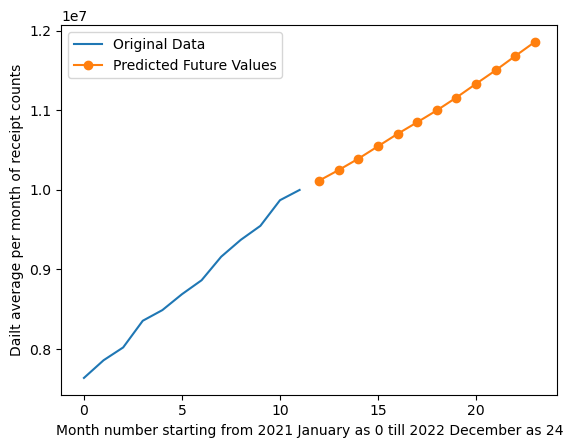

In [386]:
# Predict future values based on the fitted model
steps_ahead = 12
future_values = model.predict(steps_ahead)
print("Predicted Future Values:", future_values)

# Plot the original data and forecast
plt.plot(range(len(data)), data, label='Original Data')
plt.plot(range(len(data), len(data) + steps_ahead), future_values, marker='o', label='Predicted Future Values')
plt.legend()
plt.xlabel('Month number starting from 2021 January as 0 till 2022 December as 24')
plt.ylabel('Dailt average per month of receipt counts')
plt.show()

#### From above, trend looks pretty good and stable for future months. Therefore we can save and use this model for predictions

### Converting daily averages per month to total sum of receipts per month
### For this, we multiply the daily count prediction with the total number of days in a month to get the monthly sum

In [390]:
def days_in_month(year):
    # Dictionary with month and the number of days
    days_in_month_dict = {
        1: 31,  # January
        2: 28,  # February (default)
        3: 31,  # March
        4: 30,  # April
        5: 31,  # May
        6: 30,  # June
        7: 31,  # July
        8: 31,  # August
        9: 30,  # September
        10: 31, # October
        11: 30, # November
        12: 31  # December
    }

    # Function to check leap year
    def is_leap_year(year):
        return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)

    # Adjust February for leap years
    if is_leap_year(year):
        days_in_month_dict[2] = 29

    return days_in_month_dict

### Testing prediction for monthly sum

#### User will give us the year and month and we need to generate prediction for it. 
#### We do this by checking how many months difference we have which we can give to our model to generate prediction for those number of steps

prediction_year=2022
prediction_month=4

In [402]:
numberofdays=days_in_month(prediction_year)[prediction_month]

In [404]:
print(numberofdays)

30


In [409]:
##Number of months differnece between user month year and our last entry available
date1 = date(2021, 12, 1)
#prediction_year = 2022
#prediction_month = 4
date2 = date(prediction_year, prediction_month, 1)

years_difference = prediction_year - date1.year
months_difference = years_difference * 12 + (date2.month - date1.month)
print(months_difference)

4


In [411]:
prediction_values=model.predict(months_difference)

In [413]:
final_answer=int(prediction_values[-1]*numberofdays)

In [415]:
print(final_answer)

316522560


#### Saving the model to pickle file for flask server

In [170]:
os.getcwd()

'C:\\Users\\afiniti'

In [172]:
with open('D:\\Detritus\\Fetch Assignment\\model.pickle','wb') as f:
    pickle.dump(model,f)

### END 